# Final Project 102

Project Members: Kendall Schroth, Kachun Cheung, Samuel Edwards, Eduardo Hinojosa

### Importing Libraries and Downloading the Data

In [1]:
### Importing necessary libraries ###
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from scipy import stats
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error

In [2]:
### Downloading Data sets ###
games = pd.read_csv('/work/NBA/games.csv')
details = pd.read_csv('/work/NBA/games_details.csv')
players = pd.read_csv('/work/NBA/players.csv')
ranking = pd.read_csv('/work/NBA/ranking.csv')
teams = pd.read_csv('/work/NBA/teams.csv')
finals_dates = pd.read_csv('/work/NBA/finals_dates.csv')

/tmp/ipykernel_705/3241389580.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv('/work/NBA/games_details.csv')


## Causal Inference Dataset 

In [3]:
### creating the causal varaibles dataset
causal_columns = ["GAME_DATE_EST", 'GAME_ID', 'HOME_TEAM_ID', 
                'VISITOR_TEAM_ID', 'SEASON', 'FT_PCT_home', 'FT_PCT_away', "HOME_TEAM_WINS"]

causal_df = games.loc[:, causal_columns]
causal_df["FT_PCT_home_Z"] = (causal_df["FT_PCT_home"]-np.mean(causal_df["FT_PCT_home"]))/np.std(causal_df["FT_PCT_home"])
causal_df["FT_PCT_away_Z"] = (causal_df["FT_PCT_away"]-np.mean(causal_df["FT_PCT_away"]))/np.std(causal_df["FT_PCT_away"])

display(causal_df.head())
np.shape(causal_df)

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,FT_PCT_home,FT_PCT_away,HOME_TEAM_WINS,FT_PCT_home_Z,FT_PCT_away_Z
0,2022-12-22,22200477,1610612740,1610612759,2022,0.926,0.815,1,1.645128,0.543226
1,2022-12-22,22200478,1610612762,1610612764,2022,0.952,0.765,1,1.903385,0.059793
2,2022-12-21,22200466,1610612739,1610612749,2022,0.786,0.682,1,0.254512,-0.742705
3,2022-12-21,22200467,1610612755,1610612765,2022,0.909,0.735,1,1.476268,-0.230266
4,2022-12-21,22200468,1610612737,1610612741,2022,1.000,0.773,0,2.380168,0.137142


(26651, 10)

It is important for us to exclude play off games from the dataset; these games are not randomly assigning the location of a game. Instead, there is an intentional bias in any match up for whichever team that performed better during the regular season.

In [4]:
# excluding finals dates 
causal_df = causal_df[causal_df['GAME_DATE_EST'] < '2018-04-15']

# Causal Inference: Matching 

In [5]:
!pip install graphviz


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


To visualize the Causal Inference of our project, we made a Directed Acyclic Graph (DAG) to show the relationship amongst variables.

In [6]:
# importing necessary library to create DAG
from graphviz import Digraph

graph = Digraph(strict=True, format='png', graph_attr={'rankdir': 'LR'})

# Add nodes and connect them
graph.node('Location of Game')
graph.node('Free throw Percentage')
graph.edge('Location of Game', 'Free throw Percentage')

# Render and save the graph
graph.render('game_graph', format='png', cleanup=True)

'game_graph.png'

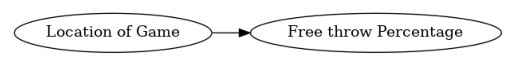

In [7]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
  
# reading png image file 
im = img.imread('game_graph.png') 
plt.axis('off')
plt.xticks([])
plt.yticks([])
  
# show image 
plt.imshow(im);

Here is where we iterate through every team and then calculate the independent treatment effect for each of them respectively. 

In [8]:
## creating matched dataset for all NBA teams to find ITE for each team
all_teams = []

_2017 = causal_df[(causal_df['SEASON'] == 2017)]

for team in teams["TEAM_ID"]:
    _id = team
    team_2017 = _2017[_2017["VISITOR_TEAM_ID"] == _id]
    team_2017 = team_2017[["HOME_TEAM_ID", "VISITOR_TEAM_ID", "FT_PCT_away"]]
    team_2017 = team_2017.rename(columns={"FT_PCT_away": "ey1"})
    team_2017 = team_2017.groupby("HOME_TEAM_ID").mean()
    team_2017 = team_2017    

    ey0 = pd.DataFrame({"HOME_TEAM_ID": [], "ey0": []}) 
    for op in team_2017.index:
        y0 = _2017[(_2017["HOME_TEAM_ID"] == _id) & (_2017["VISITOR_TEAM_ID"] == op)][["HOME_TEAM_ID", "VISITOR_TEAM_ID", "FT_PCT_home"]]
        for i in y0['FT_PCT_home']:
            ey0.loc[len(ey0.index)] = [op, i]
    ey0 = ey0.groupby("HOME_TEAM_ID").mean()
    ey0 = ey0

        
    team_2017 = pd.merge(team_2017, ey0, left_index=True, right_index=True)
    team_2017['ITE'] = team_2017['ey1'] - team_2017['ey0']

    all_teams.append(team_2017)

In [9]:
all_teams[0].head()

,VISITOR_TEAM_ID,ey1,ey0,ITE
HOME_TEAM_ID,,,,
1.610613e+09,1.610613e+09,0.849000,0.8000,0.049000
1.610613e+09,1.610613e+09,0.786667,0.8640,-0.077333
1.610613e+09,1.610613e+09,0.889000,0.7690,0.120000
1.610613e+09,1.610613e+09,0.846000,0.7800,0.066000
1.610613e+09,1.610613e+09,0.800000,0.7685,0.031500


In [10]:
df2017 = causal_df[(causal_df['SEASON'] == 2017)]
dataframes = []
for team in teams["TEAM_ID"]:
    name = str(team)
    team = df2017[df2017["VISITOR_TEAM_ID"] == team]

    team = team[["HOME_TEAM_ID", "FT_PCT_away"]]

    team = team.rename(columns={"FT_PCT_away": "ey1"})
    team = team.groupby(by = "HOME_TEAM_ID").mean()

    ey0 = pd.DataFrame({"HOME_TEAM_ID": [], "ey0": []})
    for op in team.index:
        y0 = df2017[(df2017["HOME_TEAM_ID"] == int(name)) & (df2017["VISITOR_TEAM_ID"] == op)]["FT_PCT_home"]
    #print(y0)
        for i in y0:
            ey0.loc[len(ey0.index)] = [op, i]
    ey0 = ey0.groupby(by = "HOME_TEAM_ID").mean()

    ## adding ey0 to the data set 
    team = pd.merge(team, ey0, left_index=True, right_index=True)   
 ## adding cate 
    team["CATE"] = team["ey1"] - team["ey0"]
    team["name"] = name
    dataframes.append(team) 

dataframes[0]
#np.shape(kings)

,ey1,ey0,CATE,name
HOME_TEAM_ID,,,,
1.610613e+09,0.849000,0.8000,0.049000,1610612737
1.610613e+09,0.786667,0.8640,-0.077333,1610612737
1.610613e+09,0.889000,0.7690,0.120000,1610612737
1.610613e+09,0.846000,0.7800,0.066000,1610612737
1.610613e+09,0.800000,0.7685,0.031500,1610612737
1.610613e+09,1.000000,1.0000,0.000000,1610612737
1.610613e+09,0.450000,0.9000,-0.450000,1610612737
1.610613e+09,0.909000,0.8330,0.076000,1610612737
1.610613e+09,0.724000,0.8670,-0.143000,1610612737


In [11]:
acate = pd.DataFrame({"TEAM_ID": [], "AvgCATE": []})
for df in dataframes:
    avg = np.mean(df["CATE"])
    #print(df['name'].iloc[0])
    acate.loc[len(acate.index)] = [df['name'].iloc[0], avg]
acate

,TEAM_ID,AvgCATE
0,1610612737,-0.029523
1,1610612738,0.014264
2,1610612740,-0.033115
3,1610612741,-0.028948
4,1610612742,-0.011345
5,1610612743,0.041457
6,1610612745,0.024793
7,1610612746,-0.004816
8,1610612747,-0.007937
9,1610612748,-0.011652


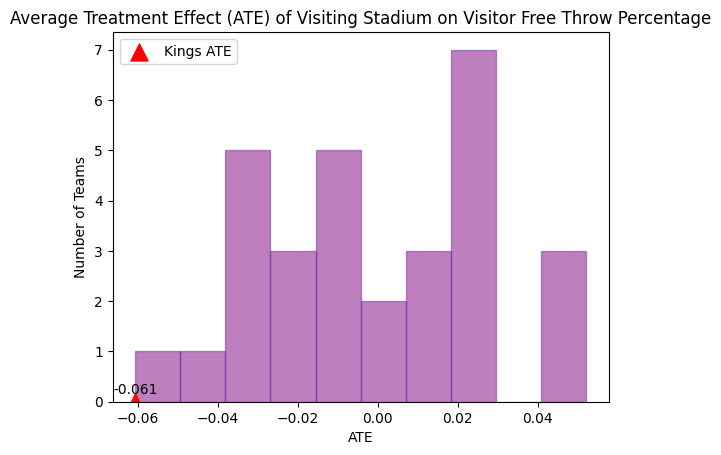

In [12]:
plt.hist(acate["AvgCATE"], color = 'purple', alpha = 0.5, edgecolor = "rebeccapurple")
plt.xlabel('ATE')
plt.ylabel("Number of Teams")
plt.title("Average Treatment Effect (ATE) of Visiting Stadium on Visitor Free Throw Percentage")
kings_ate = acate[acate["TEAM_ID"] == '1610612758'].iloc[0,1]


plt.scatter(kings_ate, 0, color='red', marker='^', label='Kings ATE', s=150)
text_y = 0.1
plt.text(kings_ate, text_y, f'{kings_ate:.3f}', color='black', ha='center', va='bottom')
plt.legend();

# Causal Inference EDA : Away Games and Free Throw Percentages

### Comparing the KDEs of the FT % for Home Games vs Away Games

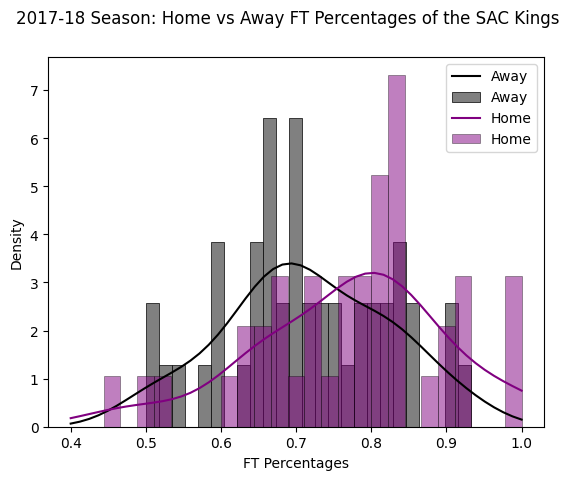

In [13]:
causal_17 = causal_df[causal_df['SEASON'] == 2017]

# 1610612764 : wizards. 1610612738 : boston, 1610612758: kings

ids4 = [1610612758]

fig, ax =  plt.subplots()

home = causal_17[causal_17['HOME_TEAM_ID'] == 1610612758]
home_FTs = home['FT_PCT_home']

away = causal_17[causal_17['VISITOR_TEAM_ID'] == 1610612758]
away_FTs = away['FT_PCT_away']

#sns.histplot(home_FTs, kde=True, bins=25, color = 'purple')#hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})

kernel = stats.gaussian_kde(away_FTs)
g_x = np.linspace(0.4, 1)
g_kde_values = kernel(g_x)

plt.plot(g_x, g_kde_values, label="Away", color = "black")
plt.hist(away_FTs, bins = 25, density = True, color = 'gray', edgecolor='black', linewidth=0.5, label='Away')

kernel1 = stats.gaussian_kde(home_FTs)
g_x1 = np.linspace(0.4, 1)
g_kde_values1 = kernel1(g_x1)

plt.plot(g_x1, g_kde_values1, label="Home", color = "purple")
plt.hist(home_FTs, bins = 25, density = True, color = 'purple', alpha = 0.5, edgecolor='black', 
    linewidth=0.5, label = 'Home')

plt.xlabel("FT Percentages")
plt.ylabel("Density")
plt.legend()
plt.suptitle('2017-18 Season: Home vs Away FT Percentages of the SAC Kings')
plt.show();

### Comparing the Spread of Home and Away Games to the Season Timeline

/tmp/ipykernel_705/2811619680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home['home?'] = (causal_17['HOME_TEAM_ID'] == ids4[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


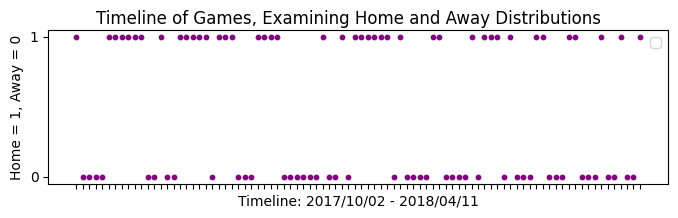

In [14]:
fig, ax =  plt.subplots(1,1, figsize=(8, 2))

home = causal_17[(causal_17['HOME_TEAM_ID'] == ids4[0]) | (causal_17['VISITOR_TEAM_ID'] == ids4[0])]
home['home?'] = (causal_17['HOME_TEAM_ID'] == ids4[0])

plt.scatter(home["GAME_DATE_EST"],home["home?"], s=10, c = 'purple')
ax.xaxis.set_tick_params(labelbottom=False)
ax.set_yticks([0, 1])

plt.xlabel("Timeline: 2017/10/02 - 2018/04/11")
plt.ylabel("Home = 1, Away = 0")
plt.legend()
plt.suptitle('Timeline of Games, Examining Home and Away Distributions')
plt.show();

### Timeline of Free Throw %, with the affect of Loss Streaks 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


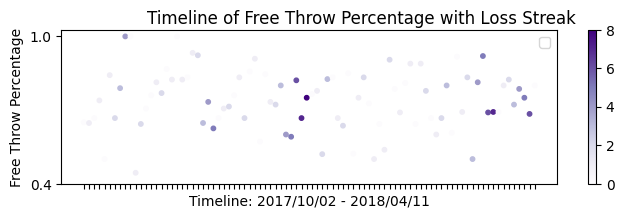

In [15]:
fig, ax =  plt.subplots(1,1, figsize=(8, 2))
ids4 = [1610612758]

home = causal_17[(causal_17['HOME_TEAM_ID'] == ids4[0]) | (causal_17['VISITOR_TEAM_ID'] == ids4[0])]

trends = pd.DataFrame({"Date": [], "ft_pct": [], "home?": [], 'home_win?': []})
for ind in home.index:
    if home['HOME_TEAM_ID'][ind] == ids4[0]:
        trends.loc[len(trends.index)] = [home["GAME_DATE_EST"][ind], home['FT_PCT_home'][ind], 1, home["HOME_TEAM_WINS"][ind]]
    elif home['VISITOR_TEAM_ID'][ind] == ids4[0]:
        trends.loc[len(trends.index)] = [home["GAME_DATE_EST"][ind], home['FT_PCT_away'][ind], 0, home["HOME_TEAM_WINS"][ind]]

prev = []
for ind in trends.index:
    if ind == 0: 
        prev.append(0)
    elif trends["home?"][ind-1] == trends["home_win?"][ind-1]:
        prev.append(1)
    elif trends["home?"][ind-1] != trends["home_win?"][ind-1]:
        prev.append(0)
trends["prev_win"] = prev

loss_streak = []
for ind in trends.index:
    i = 0
    streak = 0
    while (ind-i >= 0) & (trends["home?"][ind-i] != trends["home_win?"][ind-i]):
        streak += 1
        i += 1
    loss_streak.append(streak)
trends["loss_streak"] = loss_streak
    
#display(trends)

plt.scatter(trends["Date"],trends["ft_pct"], s=10, c = trends["loss_streak"], cmap = 'Purples')
ax.xaxis.set_tick_params(labelbottom=False)
ax.set_yticks([0.4, 1])

plt.xlabel("Timeline: 2017/10/02 - 2018/04/11")
plt.ylabel("Free Throw Percentage")
plt.colorbar()
plt.legend()
plt.suptitle('Timeline of Free Throw Percentage with Loss Streak')
plt.show();

# Prediction

### Dataset Preparation

In [16]:
players_info_lst = ["PLAYER_NAME","MIN","FG_PCT", "FG3_PCT", "FT_PCT","OREB", "DREB", 'REB', 'AST', 'STL', 'BLK','TO','PF', "PTS", 'PLUS_MINUS']
notNaN = details.loc[:, players_info_lst]['PLUS_MINUS'].notnull()
notNaN_df = details.loc[:, players_info_lst][notNaN]
notNaN_df

,PLAYER_NAME,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,Romeo Langford,18:06,1.000,0.000,0.0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,Jeremy Sochan,31:01,0.500,0.500,0.7,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,Jakob Poeltl,21:42,0.667,0.000,1.0,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,Devin Vassell,30:20,0.308,0.167,1.0,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,Tre Jones,27:44,0.583,0.333,1.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665964,CJ Miles,17:42,0.200,0.000,0.0,0.0,4.0,4.0,1.0,0.0,0.0,3.0,0.0,2.0,2.0
665965,Tyler Zeller,14:53,0.500,0.000,0.5,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0,5.0,4.0
665966,Daniel Gibson,16:11,0.600,0.500,0.5,1.0,2.0,3.0,1.0,0.0,1.0,0.0,2.0,10.0,-9.0
665967,Luke Walton,12:14,0.500,0.000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,-11.0


In [17]:
details.loc[:, players_info_lst].isnull().sum()/668628 # check how many % of Null in the dataset

PLAYER_NAME    0.000000
MIN            0.164052
FG_PCT         0.164052
FG3_PCT        0.164052
FT_PCT         0.164052
OREB           0.164052
DREB           0.164052
REB            0.164052
AST            0.164052
STL            0.164052
BLK            0.164052
TO             0.164052
PF             0.164052
PTS            0.164052
PLUS_MINUS     0.199440
dtype: float64

In [18]:
new_col = []
for i in notNaN_df['MIN']:
    split = i.split(':')
    m = split[0].split(".")
    secs = int(m[0])*60 + int(split[1])
    new_col.append(secs)
notNaN_df["SECS"] = new_col
notNaN_df

,PLAYER_NAME,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SECS
0,Romeo Langford,18:06,1.000,0.000,0.0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0,1086
1,Jeremy Sochan,31:01,0.500,0.500,0.7,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0,1861
2,Jakob Poeltl,21:42,0.667,0.000,1.0,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0,1302
3,Devin Vassell,30:20,0.308,0.167,1.0,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0,1820
4,Tre Jones,27:44,0.583,0.333,1.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0,1664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665964,CJ Miles,17:42,0.200,0.000,0.0,0.0,4.0,4.0,1.0,0.0,0.0,3.0,0.0,2.0,2.0,1062
665965,Tyler Zeller,14:53,0.500,0.000,0.5,0.0,2.0,2.0,0.0,1.0,1.0,0.0,2.0,5.0,4.0,893
665966,Daniel Gibson,16:11,0.600,0.500,0.5,1.0,2.0,3.0,1.0,0.0,1.0,0.0,2.0,10.0,-9.0,971
665967,Luke Walton,12:14,0.500,0.000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,-11.0,734


## Prediction EDA: Predicting Plus/Minus with Player Stats

## Visualizing Correlation between Plus/Minus and Other Player Stats

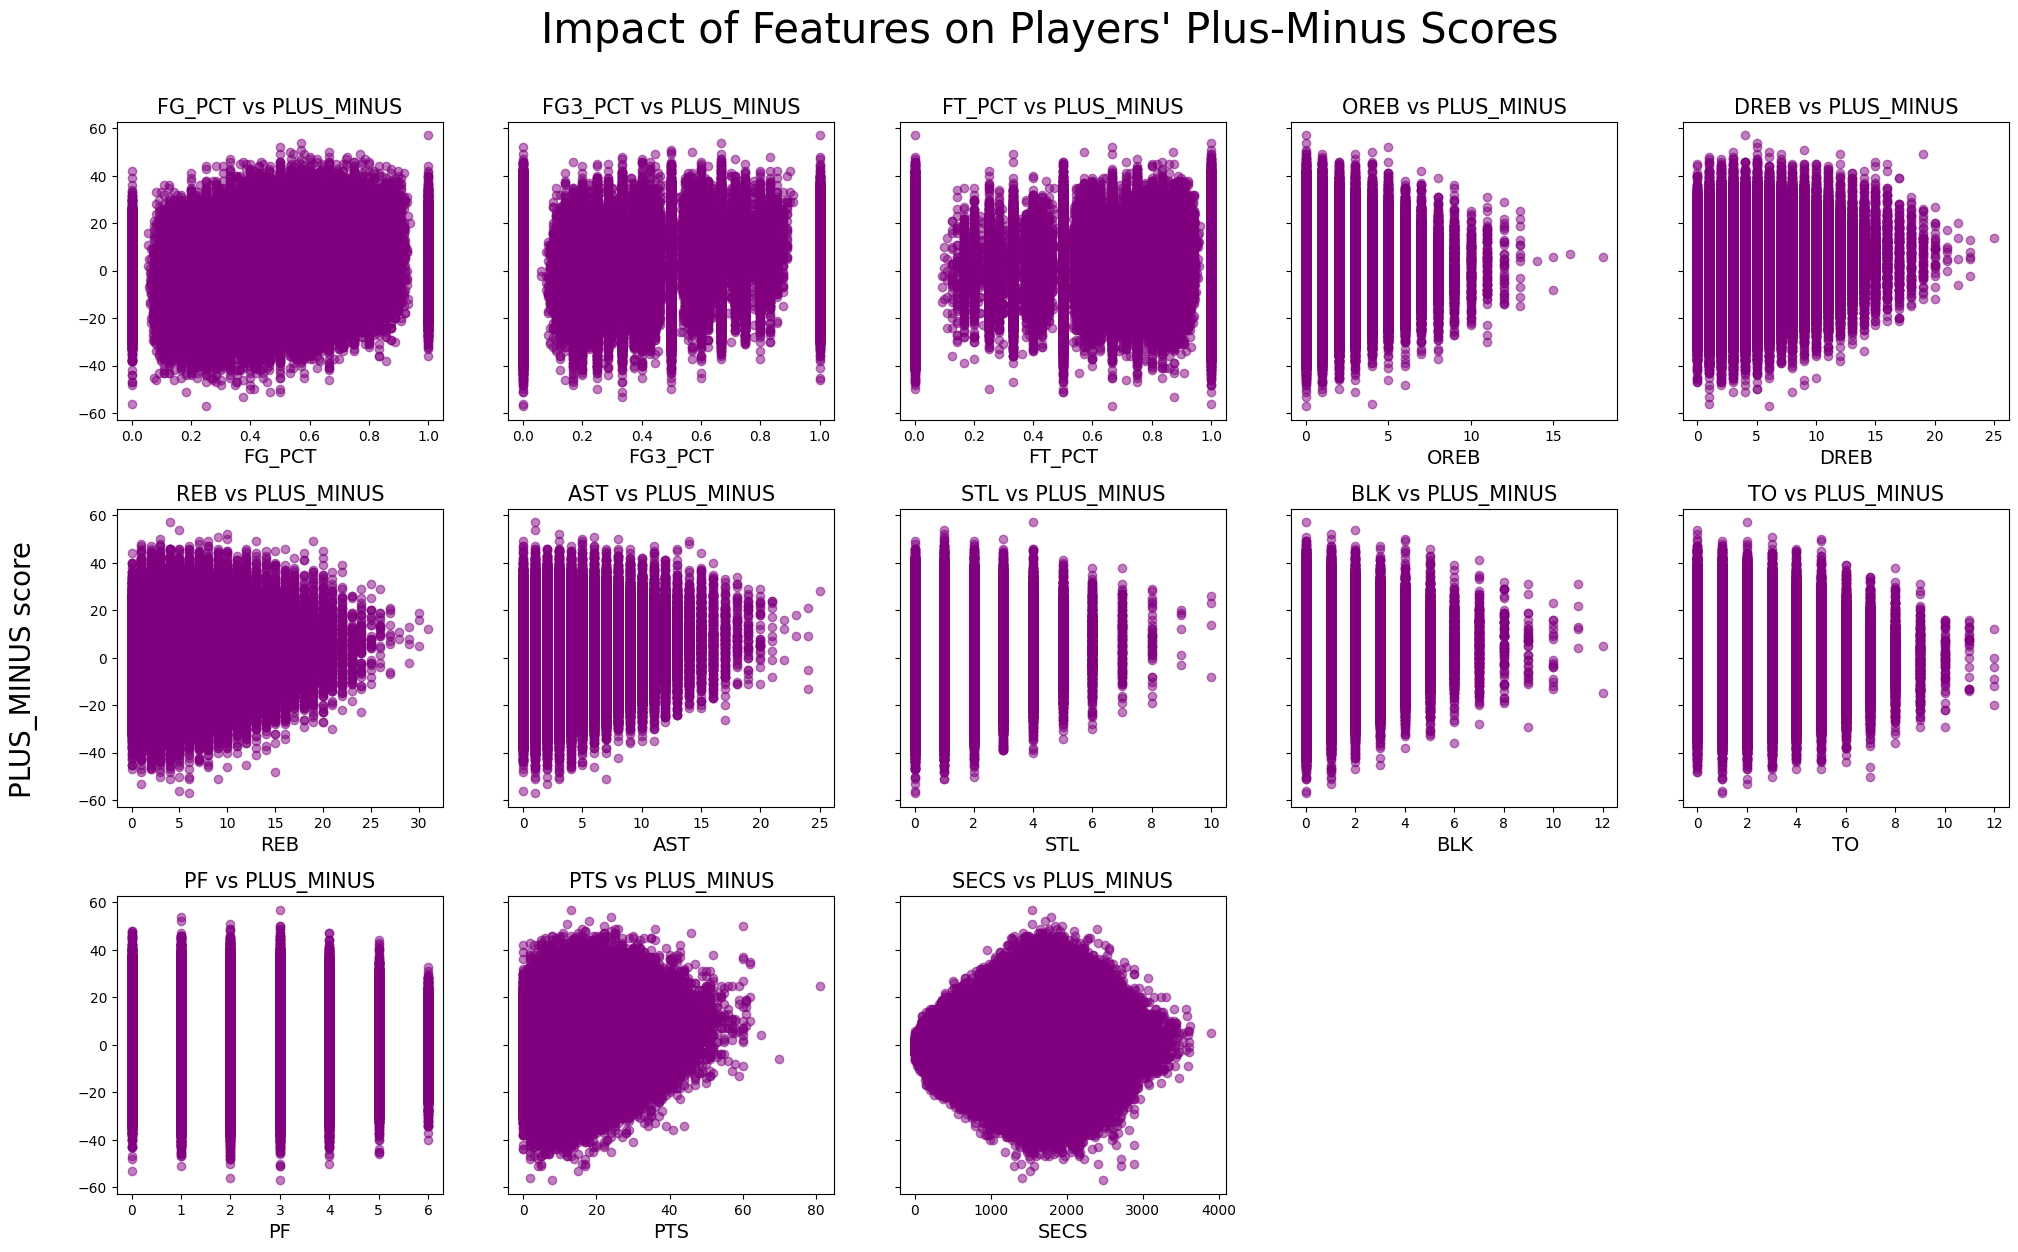

In [19]:
# Numerical Visualiztion for Predictions

p_m = notNaN_df['PLUS_MINUS']
x_s = [notNaN_df.drop('PLUS_MINUS', axis=1).iloc[:, 2:].iloc[:, i] for i in range(len(notNaN_df.drop('PLUS_MINUS', axis=1).iloc[:, 2:].columns))]

fig, axs = plt.subplots(3, 5, figsize=(20, 12), sharey=True)


axs = axs.flatten()
axs[-1].set_visible(False)
axs[-2].set_visible(False)

for i in range(13):
    ax = axs[i]
    # Add your plot data and styling here
    ax.scatter(x_s[i], p_m, color = 'purple', alpha = 0.5)
    ax.set_title(f'{x_s[i].name} vs PLUS_MINUS', fontsize=15)
    ax.set_xlabel(f'{x_s[i].name}', fontsize=14)


plt.tight_layout(pad = 2)
fig.text(-0.02, 0.5, 'PLUS_MINUS score', va='center', rotation='vertical', fontsize=20)


plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("Impact of Features on Players' Plus-Minus Scores", fontsize=30, y=1.05)
plt.show()

### Visualizing Distributions of Plus/Minus for Starting Players

In [20]:
notNaN3 = details.loc[:, ["START_POSITION","PLUS_MINUS"]]["START_POSITION"].notnull()
visualization_df = details.loc[:, ["START_POSITION","PLUS_MINUS"]][notNaN3]
visualization_df

,START_POSITION,PLUS_MINUS
0,F,-2.0
1,F,-14.0
2,C,-4.0
3,G,-18.0
4,G,0.0
...,...,...
665959,F,14.0
665960,F,20.0
665961,C,7.0
665962,G,13.0


Text(0, 0.5, 'Frequency')

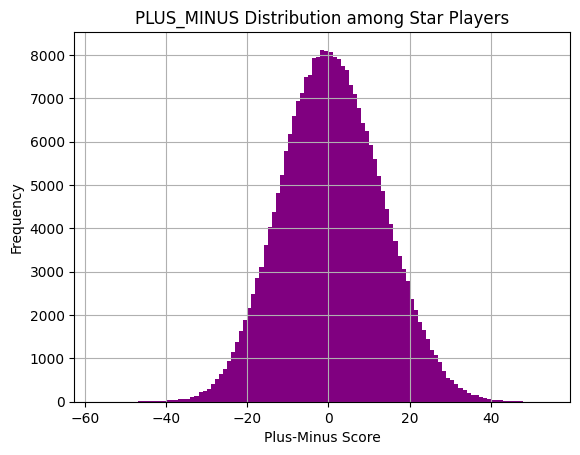

In [21]:
#plus/minus distribution for starters
starters = details[details['START_POSITION'].notnull()]
starters.hist('PLUS_MINUS', color = 'purple', bins = 111)

plt.title('PLUS_MINUS Distribution among Star Players')
plt.xlabel('Plus-Minus Score')
plt.ylabel('Frequency')

/tmp/ipykernel_705/2038782009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starters['binary_column'] = starters['PLUS_MINUS'].apply(lambda x: 1 if x > 0 else 0)


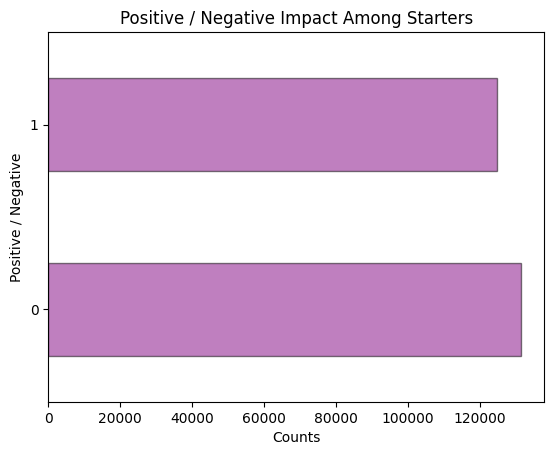

In [22]:
#binary plus/minus distribution for starters
starters['binary_column'] = starters['PLUS_MINUS'].apply(lambda x: 1 if x > 0 else 0)
starers_binary_counts = starters['binary_column'].value_counts()
starers_binary_counts.plot(kind='barh', color = 'purple', alpha = 0.5, edgecolor='black')
plt.xlabel('Counts')
plt.ylabel('Positive / Negative')
plt.title('Positive / Negative Impact Among Starters')
plt.show()

In [23]:
!pip install statsmodels==0.14.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Parametric Methods

In [24]:
import statsmodels.api as sm

Y = notNaN_df['PLUS_MINUS']
X = notNaN_df[["FG_PCT", "FG3_PCT", "FT_PCT","OREB", "DREB", 'REB', 'AST', 'STL', 'BLK','TO','PF', "PTS", "SECS"]].copy()

X = np.asarray(X)
model = sm.GLM(Y, X).fit()

print(model.summary())
print("AIC:", model.aic, "& BIC:", model.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             PLUS_MINUS   No. Observations:               535277
Model:                            GLM   Df Residuals:                   535265
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                          101.02
Method:                          IRLS   Log-Likelihood:            -1.9948e+06
Date:                Tue, 12 Dec 2023   Deviance:                   5.4071e+07
Time:                        07:08:10   Pearson chi2:                 5.41e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1185
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4327      0.056     43.817      0.0

In [25]:
model_glm_with_const = sm.GLM(Y, sm.add_constant(X)).fit()

print(model_glm_with_const.summary())
print("model_glm_with_const AIC:", model_glm_with_const.aic, "& BIC", model_glm_with_const.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             PLUS_MINUS   No. Observations:               535277
Model:                            GLM   Df Residuals:                   535264
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                          100.03
Method:                          IRLS   Log-Likelihood:            -1.9921e+06
Date:                Tue, 12 Dec 2023   Deviance:                   5.3541e+07
Time:                        07:08:16   Pearson chi2:                 5.35e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1283
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7841      0.038    -72.844      0.0

In [26]:
model_ols = sm.OLS(Y, sm.add_constant(X)).fit()
print(model_ols.summary())
print("model_ols AIC:", model_ols.aic, "& BIC", model_ols.bic)

                            OLS Regression Results                            
Dep. Variable:             PLUS_MINUS   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     6123.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        07:08:18   Log-Likelihood:            -1.9921e+06
No. Observations:              535277   AIC:                         3.984e+06
Df Residuals:                  535264   BIC:                         3.984e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7841      0.038    -72.844      0.0

0        -3.154129
1         4.532129
2        -0.339986
3         5.807746
4         0.526123
            ...   
665964   -4.976050
665965    0.371056
665966    2.718973
665967   -4.195891
665968   -4.741956
Length: 535277, dtype: float64


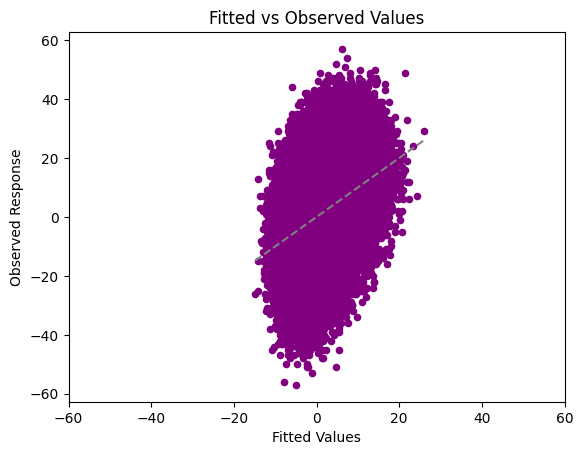

In [27]:
### model checking ###
model_ols.fittedvalues

fitted_values = model_ols.fittedvalues
print(fitted_values)
plt.scatter(fitted_values, Y, alpha = 1, s = 20, c = 'purple')
plt.plot([min(fitted_values), max(fitted_values)],[min(fitted_values), max(fitted_values)], color = 'gray', linestyle = '--')
plt.xlabel('Fitted Values')
plt.xlim(-60, 60)
plt.ylabel('Observed Response')
plt.title('Fitted vs Observed Values')
plt.show()

In [28]:
#Split the original data into training and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)

In [29]:
from sklearn.linear_model import LinearRegression
linearmodel_sk = LinearRegression()
linearmodel_sk.fit(X_train, Y_train)
print("Intercept:", linearmodel_sk.intercept_)
print("Coefficients:", linearmodel_sk.coef_)

Intercept: -2.750819869857232
Coefficients: [ 4.60168623e+00  2.52348194e+00  3.85468972e-01 -2.59292290e-01
  4.77435592e-01  2.18143302e-01  8.02885358e-01  9.06252566e-01
  7.51090448e-01 -1.15263345e+00 -1.78408090e-01  2.13344915e-01
 -3.49622166e-03]


In [30]:
from sklearn.metrics import mean_squared_error

Y_pred_2 = linearmodel_sk.predict(X_test)
accuracy_linearmodel = mean_squared_error(Y_test, Y_pred_2)
print(f"Accuracy(MSE) of Linear Regression on test set: {accuracy_linearmodel}")

Accuracy(MSE) of Linear Regression on test set: 99.03716892224077


### Non-Parametric Methods

In [31]:
#Random Forest:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest classifier
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train, Y_train)

# Predict on the test set
Y_pred_rf = rf.predict(X_test)

# Calculate the accuracy by mean_absolute_error
accuracy_rf = mean_squared_error(Y_test, Y_pred_rf)
print(f"Accuracy(MSE) of Random Forest Regressor on test set: {accuracy_rf}")

Accuracy(MSE) of Random Forest Regressor on test set: 110.38445486311059


We can use LinearRegression to predict the unknown_plus_minus_set.

In [32]:
notNaN2 = details.loc[:, players_info_lst]['FG_PCT'].notnull()
NaN = details.loc[:, players_info_lst]['PLUS_MINUS'].isnull()
unknown_plus_minus_set = details.loc[:, players_info_lst][NaN][notNaN2]
unknown_plus_minus_set.head()

/tmp/ipykernel_705/951271210.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unknown_plus_minus_set = details.loc[:, players_info_lst][NaN][notNaN2]


,PLAYER_NAME,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
138383,Bruce Bowen,19,0.500,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN
138384,Desmon Farmer,20,0.250,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0,2.0,NaN
138385,Fabricio Oberto,23,0.800,0.0,0.5,1.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,9.0,NaN
138386,Ime Udoka,21,0.625,1.0,0.0,2.0,5.0,7.0,1.0,2.0,0.0,0.0,3.0,11.0,NaN
138387,Jacque Vaughn,16,0.000,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,6.0,NaN


In [33]:
unknown_plus_minus_set['SEC'] = unknown_plus_minus_set['MIN'].astype(int) * 60
unknown_plus_minus_set.head()

,PLAYER_NAME,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEC
138383,Bruce Bowen,19,0.500,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,1140
138384,Desmon Farmer,20,0.250,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0,2.0,NaN,1200
138385,Fabricio Oberto,23,0.800,0.0,0.5,1.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,9.0,NaN,1380
138386,Ime Udoka,21,0.625,1.0,0.0,2.0,5.0,7.0,1.0,2.0,0.0,0.0,3.0,11.0,NaN,1260
138387,Jacque Vaughn,16,0.000,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,6.0,NaN,960


In [34]:
testset_X = unknown_plus_minus_set[["FG_PCT", "FG3_PCT", "FT_PCT","OREB", "DREB", 'REB', 'AST', 'STL', 'BLK','TO','PF', "PTS", "SEC"]].copy()
predict_Y = linearmodel_sk.predict(testset_X) # predict PLUS_MINUS in testset_X
predict_Y

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([-1.73100837, -3.36452479, -0.95956543, ...,  1.08224932,
       -4.52259231, -3.28759574])

In [35]:
unknown_plus_minus_set["predict_PLUS_MINUS"] = predict_Y
unknown_plus_minus_set.head()

,PLAYER_NAME,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEC,predict_PLUS_MINUS
138383,Bruce Bowen,19,0.500,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,1140,-1.731008
138384,Desmon Farmer,20,0.250,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0,2.0,NaN,1200,-3.364525
138385,Fabricio Oberto,23,0.800,0.0,0.5,1.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,9.0,NaN,1380,-0.959565
138386,Ime Udoka,21,0.625,1.0,0.0,2.0,5.0,7.0,1.0,2.0,0.0,0.0,3.0,11.0,NaN,1260,6.066033
138387,Jacque Vaughn,16,0.000,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,6.0,NaN,960,-3.690903


+/- (Plus/minus): The total point differential for the time that a specific player is on the court. This statistic measures a player's impact on the game. To calculate +/-, subtract the difference between a player’s team's total points and their opponent's total points when that player is in the game. For example, if a player's team outscored their opponents by eight points when the player is on the court, the player will receive a +8 point differential. If a player's team is outscored by five points when that player is on the court, the player will receive a -5 point differential.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f86dace4-c215-40df-9ea2-a63cc39cfa4f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>